# Results Analysis

`EP3.75` is the case where the average LMP price is $0.0375/kWh

`GC_0` is the no grid charging case where:
 - Battery only charges from PV
 - PV and Battery both receive ITC of 22%
 - Wind does not receive PTC
 
`GC_1` is the grid charging case where:
 - Battery charges from PV, Wind and Grid
 - PV receives ITC of 22%
 - Battery receives no ITC
 - Wind receives PTC of $0.015/kWh

In [21]:
# %matplotlib notebook
# import mpld3
# mpld3.enable_notebook()
import os
from pathlib import Path
import sys

if not 'workbookDir' in globals():
    workbookDir = os.getcwd()
print('workbookDir: ' + workbookDir)
os.chdir(workbookDir)

sys.path.append("/Users/dguittet/Projects/HybridSystems/HOPP")
sys.path.append("/Users/dguittet/Projects/HybridSystems/HOPP/examples/HOPP-demos")

import pandas as pd
import os
import re
import sys
import json
from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from math import *

from cycler import cycler

import json_lines # https://github.com/TeamHG-Memex/json-lines

from IPython.display import display, HTML


from matplotlib.animation import (
    PillowWriter,
    )
from matplotlib.lines import Line2D
from pylab import rcParams

from hybrid.sites import SiteInfo

from tools.optimization import setup_run, NullDataRecorder


font = {'family' : 'monospace',
        'weight' : 'medium',
        'size'   : 19}
plt.rc('font', **font)

directory = Path('/Users/dguittet/Projects/HybridSystems/HOPP/examples/HOPP-demos')
resource_dir = directory / "resource_files"
params_dir = directory / "parameter_files"
results_dir = directory / "results"

workbookDir: /Users/dguittet/Projects/HybridSystems/HOPP/examples/HOPP-demos/results


# Plot Grid Search Results with No Layout

Each of these 3D grids are created by simulating the hybrid plant performance and NPV without adding boundary constraints and wake losses. Instead, the turbines are only determined by the desired system capacity and the wake losses are fixed to 5%. This will result in overestimation of the optimal capacity of wind and pv.

/Users/dguittet/Projects/HybridSystems/HOPP/examples/HOPP-demos/results/EP3.75_GC_0_NPV
Max NPV of -0.8217406027660668 with 1 PV, 6 Wind and 0 Battery


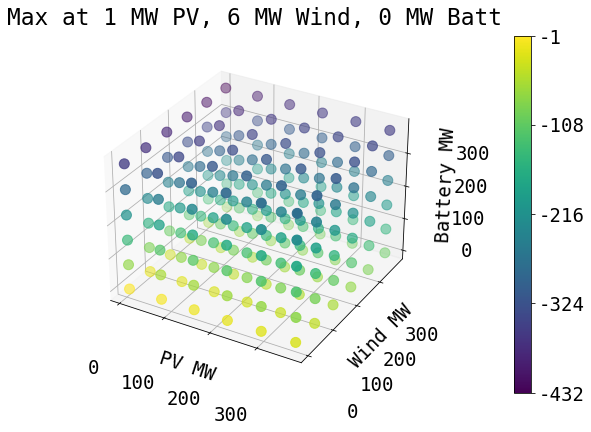

/Users/dguittet/Projects/HybridSystems/HOPP/examples/HOPP-demos/results/EP4_GC_1_NPV
Max NPV of 129.2421343414403 with 1 PV, 366 Wind and 0 Battery


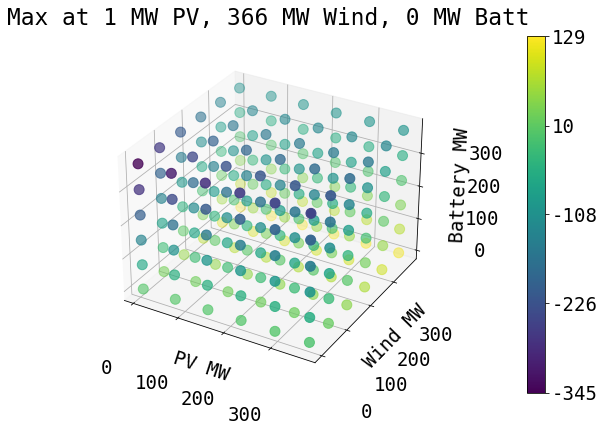

/Users/dguittet/Projects/HybridSystems/HOPP/examples/HOPP-demos/results/EP4_GC_0_NPV
Max NPV of -0.0743910264149811 with 1 PV, 6 Wind and 0 Battery


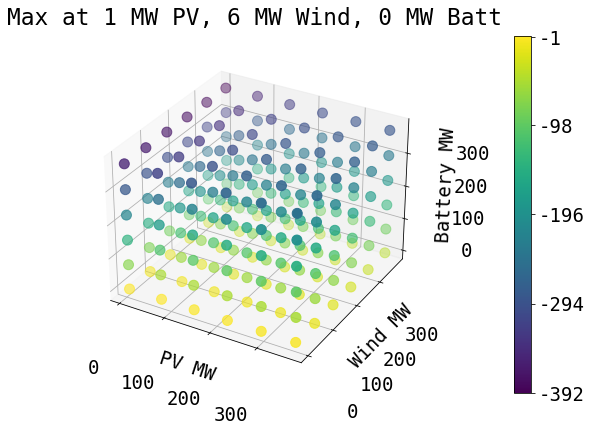

/Users/dguittet/Projects/HybridSystems/HOPP/examples/HOPP-demos/results/EP3.75_GC_1_NPV
Max NPV of 89.19620451360296 with 1 PV, 366 Wind and 0 Battery


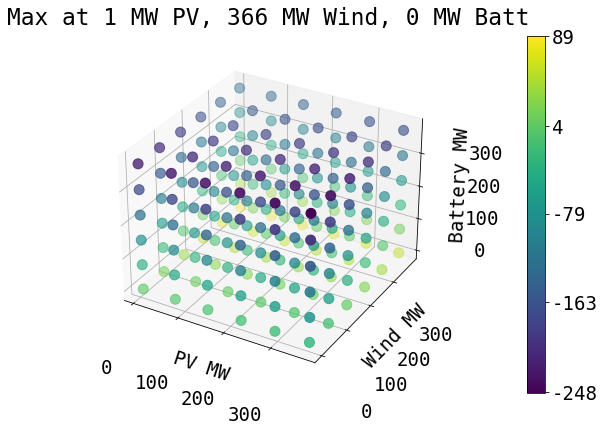

/Users/dguittet/Projects/HybridSystems/HOPP/examples/HOPP-demos/results/EP4.25_GC_0_NPV
Max NPV of 19.581865871880293 with 376 PV, 366 Wind and 0 Battery


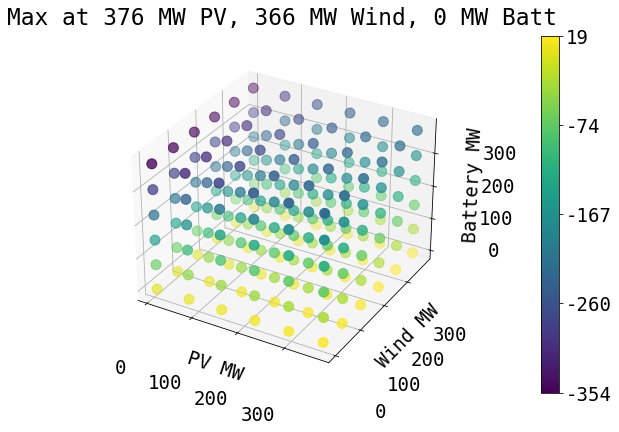

/Users/dguittet/Projects/HybridSystems/HOPP/examples/HOPP-demos/results/EP4.25_GC_1_NPV
Max NPV of 180.22355113002158 with 376 PV, 366 Wind and 0 Battery


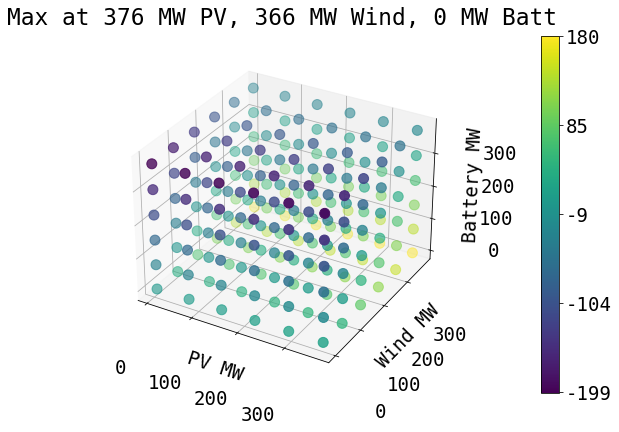

In [45]:
from mpl_toolkits.mplot3d import Axes3D
import glob

rcParams['figure.figsize'] = 8, 12
rcParams['axes.titlepad'] = 20 
rcParams['xtick.major.pad']='32'

def plot_grid(output_file):
    output_res = json.load(open(output_file, "r"))
    # Max NPV coordinates 1 366 375 172659761.8127966
    # organize data

    X = []  # solar
    Y = []  # wind
    Z = []  # battery
    NPV = []
    AEP = []
    REV = []
    CAP_PV = []
    for i in output_res:
        X.append(i[0][0])
        Y.append(i[0][1])
        Z.append(i[0][2])
        AEP.append(json.loads(i[1])['hybrid'])
        npv = json.loads(i[-2])['hybrid']
        if npv < -1e37:
            npv = min(NPV)
        NPV.append(npv)
        REV.append(json.loads(i[3])['hybrid'])
        CAP_PV.append(json.loads(i[2])['pv'])
    x_inds = sorted(list(set(X)))
    y_inds = sorted(list(set(Y)))
    z_inds = sorted(list(set(Z)))
    Xs, Ys, Zs = np.meshgrid(x_inds, y_inds, z_inds)
    NPVs = np.zeros(Xs.shape)
    AEPs = np.zeros(Xs.shape)
#     print("PV, Wind, Batt, NPV (mil)")
    for i in output_res:
        x = i[0][0]
        y = i[0][1]
        z = i[0][2]
        x_ind = x_inds.index(x)
        y_ind = y_inds.index(y)
        z_ind = z_inds.index(z)
        aep = json.loads(i[1])['hybrid']
        npv = json.loads(i[-2])['hybrid']
        cf = json.loads(i[2])
        if npv < -1e37:
            npv = min(NPV)
        NPVs[y_ind, x_ind, z_ind] = npv * 1e-6
        AEPs[y_ind, x_ind, z_ind] = aep

    # get max NPV
    max_ind = int(np.argmax(NPV))
    print(Path(output_file).parent)
    print(f"Max NPV of {NPV[max_ind] * 1e-6} with {X[max_ind]} PV, {Y[max_ind]} Wind and {Z[max_ind]} Battery")

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    # ax.plot_trisurf(X, Y, Z, edgecolor="gray", color="None")
    img = ax.scatter(Y, X, Z, c=NPVs, s=100)
    # ax.scatter( X[max_ind], Y[max_ind], Z[max_ind], s=320, marker='*', color='tomato')
    ax.set_xlabel("PV MW")
    ax.set_ylabel("Wind MW")
    ax.set_zlabel("Battery MW")
    cbar = fig.colorbar(img, fraction=0.04, pad=0.2)
    m0 = int(np.ceil(NPVs.min()))            # colorbar min value
    m4 = int(np.floor(NPVs.max()))             # colorbar max value
    m1 = int(1 * (m4-m0) / 4.0 + m0)               # colorbar mid value 1
    m2 = int(2 * (m4-m0) / 4.0 + m0)               # colorbar mid value 2
    m3 = int(3 * (m4-m0) / 4.0 + m0)               # colorbar mid value 3
    cbar.set_ticks([m0, m1, m2, m3, m4])
    cbar.set_ticklabels([m0, m1, m2, m3, m4])
#     plt.suptitle(f"Grid of NPVs in $M")
    plt.title(f"Max at {X[max_ind]} MW PV, {Y[max_ind]} MW Wind, {Z[max_ind]} MW Batt")
    plt.savefig(Path(output_file).parent / "grid_view.png")
    plt.show()

for f in glob.glob(str(results_dir / "*" / "*grid.json")):
    plot_grid(f)

In [27]:
# print(os.listdir('.'))
# print(os.path.dirname(os.path.realpath('.')))

def load_results(path, run_group, index='iteration'):
#     run_name_extractor = re.compile(r'^(.*)_(\d\d\d\d\-\d\d\-\d\dT\d\d\.\d\d\.\d\d\.\d+)$')
    run_name_extractor = re.compile(r'^(.*)_([^_]+)$')
    
    dirs = [f for f in os.listdir(path)]
    print(dirs)
#     source_files = [os.path.join([p for p in os.listdir(d) if p.endswith('log.jsonl')][0],d,path) for d in dirs]
#     print(source_files)
#     pprint(os.listdir(path))

#     aggregated_columns = {}
    data_sets = {}
    for d in dirs:
#         match = run_name_extractor.match(d)
#         if not match:
#             continue
        
        dir_path = os.path.join(path, d)
        print(dir_path)
#         print(match, run_group, run_name)
#         files = [p for p in os.listdir(dir_path) if p.endswith('log.jsonl')]
#         if len(files) == 0:
#             print('skipping', d)
#             continue # skip this directory
        if '.jsonl' not in dir_path:
            continue
            
        if 'copy' in dir_path:
            continue
    
        f = os.path.join(dir_path)
        
        columns = []
        data = None
        with open(f, 'rb') as file:
            print(f)
            columns = next(json_lines.reader(file))

            data_set = pd.DataFrame(json_lines.reader(file), columns = columns)

        data_set.set_index(index, inplace=True)
        
        if run_group not in data_sets:
            data_sets[run_group] = {}
        run_data_sets = data_sets[run_group]
        run_data_sets[run_group] = data_set
        
    return data_sets

def make_aggregated_data_set(data_sets):
    aggregated_data_sets = {}
    for run_group, runs in data_sets.items():
        group_data = {}
        for run_name, data_set in runs.items():
            for column in data_set.columns:
                if column not in group_data:
                    group_data[column] = pd.DataFrame()
                group_data[column][run_name] = data_set[column]
        aggregated_data_sets[run_group] = group_data
    return aggregated_data_sets


def extract_solution_vars(data_sets, solution_vars, solution_name = 'best_solution'):
    for run_group, runs in data_sets.items():
        for run_name, data_set in runs.items():
            solutions = data_set[solution_name]
            if solution_vars is None:
                solution_vars = sorted(solutions.iloc[0].keys())
            for n, var in enumerate(solution_vars):
                data_set[solution_name + '.' + var] = [row[n] for row in solutions]
    return solution_vars

def unpack_solution_vars(data_sets, solution_vars, solution_name):
    for run_group, runs in data_sets.items():
        for run_name, data_set in runs.items():
            solutions = data_set[solution_name]
            for i, var in enumerate(solution_vars):
                data_set[solution_name + '.' + var] = [row[i] for row in solutions]
            
def load_and_preprocess(directory, run_name):
    data_sets = load_results(directory, run_name)
    print('data_sets', data_sets)
    extract_solution_vars(data_sets, solution_vars)
    unpack_solution_vars(data_sets, solution_vars, 'mean')
    unpack_solution_vars(data_sets, solution_vars, 'variance')
    aggregated_data_sets = make_aggregated_data_set(data_sets)

    for j, (run_group, group_data) in enumerate(aggregated_data_sets.items()):
        print(run_group)
    return data_sets, aggregated_data_sets, solution_vars


In [29]:
from pathlib import Path
from optimize_npv import HybridLayoutProblem, WindBoundaryGridParameters, PVGridParameters, module_power, simulation_options
from hybrid.sites import make_irregular_site

solution_vars = ["border_spacing", "border_offset", "grid_angle", "grid_aspect_power", "row_phase_offset", "num_turbines_ratio_max", "solar_x_position", "solar_y_position", "solar_aspect_power", "solar_gcr", "solar_s_buffer", "solar_x_buffer", "solar_ratio_of_max_mw", "battery_ratio_of_max_mw"]
location = (32.4386, -99.7336, 0)

def create_hybrid_plant():
    solar_file = resource_dir / "32.43861838431444__-99.73363995829895_32.438818_-99.734703_psm3_60_2013.csv"
    wind_file = resource_dir / "lat32.43_lon-99.73__2013_120m.srw"
    prices_file = resource_dir / "pricing-data-2015-IronMtn-002_factors.csv"
    site = SiteInfo(make_irregular_site(lat=location[0], lon=location[1], elev=location[2]),
                    solar_resource_file=solar_file,
                    wind_resource_file=wind_file,
                    grid_resource_file=prices_file)
    
    with open(params_dir / "pv_parameters.json", 'r') as f:
        pv_info = json.load(f)["SystemDesign"]
    with open(params_dir / "wind_parameters.json", 'r') as f:
        wind_info = json.load(f)
    turb_rating_kw = max(wind_info['Turbine']['wind_turbine_powercurve_powerout'])
    with open(params_dir / "financial_parameters.json", 'r') as f:
        fin_info = json.load(f)
    cost_info = fin_info['capex']
        
    problem = HybridLayoutProblem(site_info=site, cost_config=dict(), sim_config=simulation_options, dispatch_config=dict(), 
                                  turb_size_kw=6000, pv_config=pv_info, wind_config=wind_info,
                                  fin_config=fin_info)
    return problem

problem = create_hybrid_plant()

bounds = problem.site.polygon.bounds
site_sw_bound = np.array([bounds[0], bounds[1]])
site_ne_bound = np.array([bounds[2], bounds[3]])
site_center = .5 * (site_sw_bound + site_ne_bound)
max_delta = max(bounds[2] - bounds[0], bounds[3] - bounds[1])
reach = (max_delta / 2) * 1.3
min_plot_bound = site_center - reach
max_plot_bound = site_center + reach

In [30]:
# colors = [
#     (0.0,0.0,1.0),
#     (0.0,1.0,0.0),
#     (1.0,0.0,0.0),
#     (0.0,0.7,0.7),
#     (0.7,0.7,0.0),
#     (0.0,0.0,0.0),
#     (0.5,0.5,0.5),
# ]

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# plt.style.use('seaborn-whitegrid')
plt.ion()

rcParams['lines.linewidth'] = 4

wind_color = (153 / 255, 142 / 255, 195 / 255)
solar_color = (241 / 255, 163 / 255, 64 / 255)
batt_color = (65 / 255, 121 / 255, 251 / 255)
flicker_color = (27/255.0,158/255.0,119/255.0)


colors = [
#     (67/255.0,185/255.0,269/255.0),
    (223 / 255, 142 / 255, 195 / 255),
    (86 / 255, 163 / 255, 64 / 255),
    (165 / 255, 121 / 255, 251 / 255),
    (127/255.0, 58/255.0,119/255.0)
]

solar_max_mw = 300
turbines_max = 62
battery_max_mw = 300
def plot_site(candidate, min_plot_bound, max_plot_bound, site_fig_size, title):

    site_border_color = (0, 0, 0)
    fig, ax = plt.subplots(1, figsize=site_fig_size)
    ax.axis('scaled')
    ax.set(xlim=(min_plot_bound[0], max_plot_bound[0]), ylim=(min_plot_bound[1], max_plot_bound[1]))
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis("off")
    ax.margins(y=0, x=0)
    
    problem = create_hybrid_plant()
    simulation = problem._set_simulation_to_candidate(candidate)
    simulation.site.plot(fig, ax, site_border_color)
    simulation.layout.plot(fig, ax,
                           wind_color='b',
                           pv_color=solar_color,
                           site_border_color=site_border_color)
    
    plt.tight_layout()
    wind_mw = simulation.wind.num_turbines * 6
    solar_mw = simulation.pv.system_capacity_kw * 1e-3
    batt_mw = simulation.battery.system_capacity_kw * 1e-3
    plt.title(f"{round(wind_mw)} MW Wind, {round(solar_mw)} MW Solar, {round(batt_mw)} MW Battery")
    plt.suptitle(title)
    plt.margins(0,0)
    plt.show()

    return fig
    
def plot_sites(runs, group_name, site_fig_size):
    ds = None
    for j, (run_name, data_set) in enumerate(runs.items()):
    #     print(run_name)
        ds = data_set
        json_candidate = data_set.at[len(data_set.index)-1, 'best_solution']
        evaluation = data_set.at[len(data_set.index)-1, 'best_evaluation']
        title = run_name.split('.jsonl')[0] + f"x Best NPV ${round(evaluation * 1e-6, 2)}M"
        fig = plot_site(json_candidate, min_plot_bound, max_plot_bound, site_fig_size, title)
        score = data_set.at[len(data_set.index)-1, 'best_score']
        baseline_value = data_set.at[data_set.index[0], 'best_score']

        print(json_candidate, score, evaluation, run_name)

#         plt.label(str(evaluation / 1e3) + 'GWh AEP')
#         plt.savefig(group_name + '_' + str(j) + '_layout.svg')
        fig.savefig(results_dir / "fig_layout.png")
#         fig2.savefig(group_name + '_' + str(j) + '_stats.svg')
    
    return json_candidate, evaluation, score, baseline_value

In [31]:

def smooth_aggregated_column(aggregated_column, window_size):
    print('ws ', window_size)
    return aggregated_column.rolling(window=window_size,axis=0).mean()

def plot_quantile(ax, x, aggregated_column, color=(0,0,.8), alpha=.25, value=.5):
    q1 = aggregated_column.quantile(.5+value/2, 1).values.tolist()
    q2 = aggregated_column.quantile(.5-value/2, 1).values.tolist()
    ax.fill_between(x, q1, q2, color=(*color, alpha))

def plot_quantiles(ax, x, aggregated_column, color=(0,0,.8), alpha=.5, value=.5):
#     plot_quantile(ax, x, aggregated_column, color, alpha, value)
    plot_quantile(ax, x, aggregated_column, color, alpha * .5, value * 2)
    ax.plot(x, aggregated_column.quantile(.5, 1), color=color)

def plot_smooth_quantiles(x, aggregated_column, window_size=5, **kwargs):
    plot_quantiles(x, smooth_aggregated_column(aggregated_column, window_size), **kwargs)
    
def normalize_sequence(seq):
    hi = max(seq)
    lo = min(seq)
    scale = max(1e-6, hi - lo)
    return [(x-lo) / scale for x in seq]


def setup_minor_ticks(ax):
    ax.minorticks_on()
    ax.tick_params(which='major', length=8)
    ax.tick_params(which='minor', length=4)

def plot_perf(aggregated_data_sets, baseline_value, ordering, figsize=(10,8)):
    def aep_to_pct(x):
        return x * 1e-6

    def gwh_to_pct(x):
        return x

    def pct_to_gwh(y):
        return y

    fig, ax = plt.subplots(1, figsize=figsize)
    
    ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
    setup_minor_ticks(ax)

    ax.minorticks_on()

    plt.ylabel('NPV ($mil)')
    plt.xlabel('# of candidates evaluated')
    
    labels = []
        
    for i, run_group in enumerate(ordering):
        run_data = aggregated_data_sets[run_group]
        scores = run_data['best_evaluation']
        pct = aep_to_pct(scores)
        plot_quantiles(ax, run_data['num_evaluations'].median(1) + 200, pct, color=colors[i%len(colors)])
        labels.append(run_group)
        
#         print(scores.mean(1).values[-1])
        print('{} mean {} stdev {} median {}\n'.format(run_group, pct.mean(1).values[-1], pct.std(1).values[-1], pct.median(1).values[-1]))
    
    return fig, ax, None


In [80]:
data_sets = load_results(results_dir/"EP4.25_GC_0_NPV", "EP4.25_GC_0_NPV")

['results.log.jsonl', 'README.json']
/Users/dguittet/Projects/HybridSystems/HOPP/examples/HOPP-demos/results/EP4.25_GC_0_NPV/results.log.jsonl
/Users/dguittet/Projects/HybridSystems/HOPP/examples/HOPP-demos/results/EP4.25_GC_0_NPV/results.log.jsonl
/Users/dguittet/Projects/HybridSystems/HOPP/examples/HOPP-demos/results/EP4.25_GC_0_NPV/README.json


In [49]:
print(data_sets['EP4.25_GC_0_NPV']['EP4.25_GC_0_NPV']['best_solution'].values[-1])
print(data_sets['EP4.25_GC_0_NPV']['EP4.25_GC_0_NPV']['best_score'].values[-1])

[6.668898285389989, 0.2667479500819712, 3.141592653589793, 1.2467727580680057, 0.38554307109486374, 0.1485446475981471, 0.5367749167505199, 0.13926477866524764, 0.3610686792864124, 0.1, 0.0, 7.327814085916537, 1.0, 0.010245800930107449]
29315707.661247123


In [48]:
data_sets['EP4.25_GC_0_NPV']['EP4.25_GC_0_NPV']

,generation,mean,variance,covariance,_sigma,_p_c,_p_sigma,num_evaluations,best_score,best_evaluation,best_solution,best_solution.border_spacing,best_solution.border_offset,best_solution.grid_angle,best_solution.grid_aspect_power,best_solution.row_phase_offset,best_solution.num_turbines_ratio_max,best_solution.solar_x_position,best_solution.solar_y_position,best_solution.solar_aspect_power,best_solution.solar_gcr,best_solution.solar_s_buffer,best_solution.solar_x_buffer,best_solution.solar_ratio_of_max_mw,best_solution.battery_ratio_of_max_mw,mean.border_spacing,mean.border_offset,mean.grid_angle,mean.grid_aspect_power,mean.row_phase_offset,mean.num_turbines_ratio_max,mean.solar_x_position,mean.solar_y_position,mean.solar_aspect_power,mean.solar_gcr,mean.solar_s_buffer,mean.solar_x_buffer,mean.solar_ratio_of_max_mw,mean.battery_ratio_of_max_mw,variance.border_spacing,variance.border_offset,variance.grid_angle,variance.grid_aspect_power,variance.row_phase_offset,variance.num_turbines_ratio_max,variance.solar_x_position,variance.solar_y_position,variance.solar_aspect_power,variance.solar_gcr,variance.solar_s_buffer,variance.solar_x_buffer,variance.solar_ratio_of_max_mw,variance.battery_ratio_of_max_mw
iteration,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,"[[-13844485.846713472, -13844459.637672722, [4...","[5.192813433583851, 0.34117701092000224, 1.589...","[23.225124857329178, 3.594338216134966, 9.3530...","[[23.225124857329178, -0.04442402644097136, 0....",0.720658,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....","[[0.29209325901058425], [-0.6015027535154064],...",100,-1.384449e+07,-1.384446e+07,"[4.119680613854861, 0.7487316179477335, 3.1415...",4.119681,0.748732,3.141593,1.136531,0.821493,0.053382,0.575396,1.000000,-2.514021,0.168130,1.517870,4.719997,0.612322,0.279567,5.192813,0.341177,1.589329,0.099958,0.583610,0.178786,0.584384,0.550675,-0.460639,0.283292,3.876216,4.606876,0.545324,0.391180,23.225125,3.594338,9.353017,8.761903,0.253333,0.277825,0.239987,0.266355,8.979034,0.255341,15.748143,15.442461,0.041065,0.044130
2,"[[13351083.160885079, 13351088.790838897, [9.1...","[5.112903710629213, 0.2794942585203936, 1.8741...","[22.256321199678894, 3.189561287944212, 8.5811...","[[22.256321199678894, -0.1250768932219979, -0....",1.059019,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....","[[0.05148450038422453], [-0.4342339276073748],...",200,1.335108e+07,1.335109e+07,"[9.142647927768651, 0.0, 2.080217680126804, 1....",9.142648,0.000000,2.080218,1.833181,0.561528,0.000000,1.000000,0.202930,2.728221,0.330175,1.427047,0.785633,0.919046,0.029018,5.112904,0.279494,1.874169,0.577679,0.498090,0.054907,0.603324,0.486660,-0.466702,0.243836,3.594636,4.381555,0.648183,0.216872,22.256321,3.189561,8.581169,8.446253,0.243986,0.250202,0.225351,0.254581,8.710273,0.229568,15.665648,15.063287,0.042256,0.048586
3,"[[16205400.629246792, 16205421.185244262, [2.6...","[6.351359597355012, 0.5650134280806285, 1.6539...","[21.650647076573, 2.83076689373208, 7.72525987...","[[21.650647076573, -0.04146541843086797, -0.20...",1.422463,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....","[[0.8920799558220053], [0.41778548917937086], ...",300,1.620540e+07,1.620542e+07,"[2.668001998201257, 0.0, 3.141592653589793, 0....",2.668002,0.000000,3.141593,0.192913,0.178042,0.000000,0.508261,0.567102,2.537440,0.100000,3.180729,3.157497,0.744586,0.038161,6.351360,0.565013,1.653930,0.859712,0.368908,0.059825,0.745141,0.511162,1.531048,0.183410,2.019391,4.244572,0.683603,0.051092,21.650647,2.830767,7.725260,8.212267,0.229551,0.222225,0.209119,0.235055,8.482436,0.204448,14.516076,14.168016,0.040756,0.045815
4,"[[21852137.26094335, 21852187.30557221, [7.718...","[6.840206170660701, 0.4665227359656806, 2.0885...","[20.12806123791804, 2.486300095513422, 6.88705...","[[20.12806123791804, -0.009281614305193267, -0...",1.468406,"[[0.9800468803737296], [-0.19745560432259499],...","[[0.7373266547605298], [0.03444709070608745], ...",400,2.185214e+07,2.185219e+07,"[7

In [47]:
runs = ("EP3.75_GC_0_NPV", "EP3.75_GC_1_NPV", "EP4_GC_0_NPV", "EP4_GC_1_NPV", "EP4.25_GC_0_NPV", "EP4.25_GC_1_NPV")
# runs = ["25_GC_0_NPV"]
aggregated_data_sets = dict()
data_sets = dict()
for r in runs:
    data_set, aggregated_data_set, _ = load_and_preprocess(results_dir / r, r)
    aggregated_data_sets.update(aggregated_data_set)
    data_sets.update(data_set)
aggregated_data_sets.keys()


['results.log.jsonl', 'results1.log.jsonl', 'README.json', 'results2.log.jsonl', 'grid_view.png', 'hybrid_size_grid.json']
/Users/dguittet/Projects/HybridSystems/HOPP/examples/HOPP-demos/results/EP3.75_GC_0_NPV/results.log.jsonl
/Users/dguittet/Projects/HybridSystems/HOPP/examples/HOPP-demos/results/EP3.75_GC_0_NPV/results.log.jsonl
/Users/dguittet/Projects/HybridSystems/HOPP/examples/HOPP-demos/results/EP3.75_GC_0_NPV/results1.log.jsonl
/Users/dguittet/Projects/HybridSystems/HOPP/examples/HOPP-demos/results/EP3.75_GC_0_NPV/results1.log.jsonl
/Users/dguittet/Projects/HybridSystems/HOPP/examples/HOPP-demos/results/EP3.75_GC_0_NPV/README.json
/Users/dguittet/Projects/HybridSystems/HOPP/examples/HOPP-demos/results/EP3.75_GC_0_NPV/results2.log.jsonl
/Users/dguittet/Projects/HybridSystems/HOPP/examples/HOPP-demos/results/EP3.75_GC_0_NPV/results2.log.jsonl
/Users/dguittet/Projects/HybridSystems/HOPP/examples/HOPP-demos/results/EP3.75_GC_0_NPV/grid_view.png
/Users/dguittet/Projects/HybridSyst

data_sets {'EP3.75_GC_1_NPV': {'EP3.75_GC_1_NPV':                                                   generation  \
iteration                                                      
1          [[-49671879.30703893, -49671857.280050635, [2....   
2          [[-36200913.63472391, -36200910.2299552, [3.16...   
3          [[0, 0, [7.81170968583958, 0.44493625446167284...   
4          [[10712589.324569402, 10712605.762080252, [7.5...   
5          [[2022579.7439872532, 2022615.9346796274, [5.7...   
6          [[0, 0, [21.46863952968205, 0.0457163436394311...   
7          [[950812.2010595622, 950896.5778543949, [20.05...   
8          [[11738088.030735193, 11738181.8316679, [13.91...   
9          [[0, 0, [11.16076805408596, 1.0, 2.38596255110...   
10         [[1301308.503324005, 1301320.1637402177, [25.4...   
11         [[3897563.4817202687, 3897563.4904994965, [10....   
12         [[9424493.358157054, 9424495.609568655, [11.58...   

                                                     

data_sets {'EP4_GC_0_NPV': {'EP4_GC_0_NPV':                                                   generation  \
iteration                                                      
1          [[-36350798.548924215, -36350759.66181874, [7....   
2          [[0, 0, [3.7592670089134415, 0.0, 3.1415926535...   
3          [[0, 0, [2.515829088027264, 0.0, 3.14159265358...   
4          [[0, 0, [16.974452890098902, 0.0, 0.0, 3.03291...   
5          [[352254.08193558326, 352374.62992054224, [17....   
6          [[0, 0, [22.239877638616136, 1.0, 3.1415926535...   
7          [[0, 0, [31.191444441190114, 1.0, 0.0, 1.14925...   
8          [[0, 0, [15.1281845881239, 0.0, 0.0, 4.0, 1.0,...   
9          [[0, 0, [21.90520844585468, 1.0, 0.07749674590...   
10         [[1048423.8683568423, 1048425.4578586817, [16....   
11         [[0, 0, [26.00799075826557, 0.0, 0.0, 1.570365...   
12         [[0, 0, [19.835524304855234, 0.0, 1.8608146044...   

                                                        mea

data_sets {'EP4_GC_1_NPV': {'EP4_GC_1_NPV':                                                   generation  \
iteration                                                      
1          [[-6065352.302922368, -6065352.302922368, [10....   
2          [[10125642.92346959, 10125643.09089011, [4.864...   
3          [[34238476.5104679, 34238478.724927306, [10.99...   
4          [[17367899.50211962, 17367900.91626489, [14.98...   
5          [[25035658.629338644, 25035689.070732415, [3.5...   
6          [[12217790.308241412, 12217801.573981643, [3.4...   
7          [[28740890.264112175, 28740915.60906458, [4.38...   
8          [[34804718.9762906, 34804737.497733116, [13.57...   
9          [[24511923.3085175, 24511926.29318267, [5.8016...   
10         [[28825709.325564418, 28825729.420520723, [4.6...   
11         [[34308501.28388132, 34308515.352384746, [12.0...   

                                                        mean  \
iteration                                                  

data_sets {'EP4.25_GC_1_NPV': {'EP4.25_GC_1_NPV':                                                   generation  \
iteration                                                      
1          [[7402170.898935113, 7402171.404513359, [3.880...   
2          [[39414785.509894006, 39414797.22025931, [10.2...   
3          [[59879833.29898789, 59879844.752036214, [5.04...   
4          [[54639976.76547872, 54640094.19444901, [5.997...   
5          [[43358941.22631073, 43359028.90984464, [8.858...   
6          [[39193249.70698104, 39193253.60743928, [6.012...   
7          [[58710938.651178144, 58710964.6565004, [6.521...   
8          [[59585811.7898036, 59585949.91095042, [12.890...   
9          [[56353519.58430068, 56353519.825082004, [5.87...   
10         [[66827850.27790253, 66827852.68381274, [9.825...   
11         [[53942159.31565942, 53942196.847118616, [11.1...   

                                                        mean  \
iteration                                            

dict_keys(['EP3.75_GC_0_NPV', 'EP3.75_GC_1_NPV', 'EP4_GC_0_NPV', 'EP4_GC_1_NPV', 'EP4.25_GC_0_NPV', 'EP4.25_GC_1_NPV'])

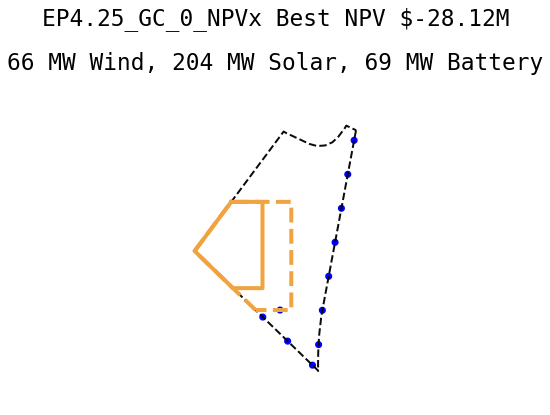

[3.5696879052628643, 0.29718435505181384, 0.6046031932713732, 2.1544000941809838, 0.3243849899404435, 0.18995934016064742, 0.16602185489010907, 0.5135321200994504, 0.04902842509415295, 0.1, 4.784775870311071, 6.608491213543713, 0.6789520881864707, 0.22949661784553793] -28117004.8020224 -28117004.600948155 EP4.25_GC_0_NPV
[3.5696879052628643, 0.29718435505181384, 0.6046031932713732, 2.1544000941809838, 0.3243849899404435, 0.18995934016064742, 0.16602185489010907, 0.5135321200994504, 0.04902842509415295, 0.1, 4.784775870311071, 6.608491213543713, 0.6789520881864707, 0.22949661784553793] -28117004.600948155 -28117004.8020224 -48444617.02630009
-48444617.02630009
EP4.25_GC_0_NPV mean 7.625806074734002 stdev nan median 7.625806074734002



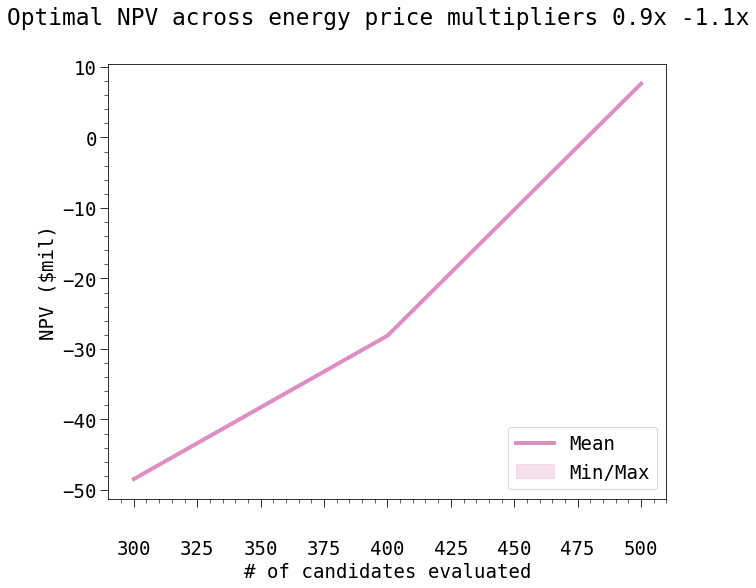

-48444617.02630009


In [38]:
current_run = run_group = 'EP4.25_GC_0_NPV'
runs = data_sets[run_group]
site_fig_size = (5,7)
best_solution, evaluation, score, baseline_value = plot_sites(runs, run_group, site_fig_size)
print(best_solution, evaluation, score, baseline_value)

ordering = [current_run]
print(baseline_value)
fig, ax, ax2 = plot_perf(aggregated_data_sets, 0.1, ordering)
plt.legend(["Mean", "Min/Max"], loc='lower right')

plt.suptitle("Optimal NPV across energy price multipliers 0.9x -1.1x")
plt.show()
print(baseline_value)

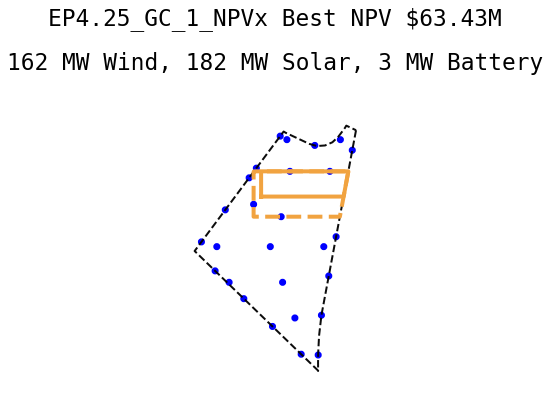

[4.277015828506016, 0.509881631963763, 3.141592653589793, -0.40524681412724906, 0.7701112115225583, 0.43899912717548045, 0.7327013641802729, 0.7623341353643145, -1.412184634371493, 0.3149578925279668, 4.3186975957964275, 0.9843775997683757, 0.6077832173974904, 0.010431902974099315] 63428591.22929705 63428592.95354718 EP4.25_GC_1_NPV
[4.277015828506016, 0.509881631963763, 3.141592653589793, -0.40524681412724906, 0.7701112115225583, 0.43899912717548045, 0.7327013641802729, 0.7623341353643145, -1.412184634371493, 0.3149578925279668, 4.3186975957964275, 0.9843775997683757, 0.6077832173974904, 0.010431902974099315] 63428592.95354718 63428591.22929705 5521692.76252748
5521692.76252748
EP4.25_GC_1_NPV mean 63.428592953547174 stdev nan median 63.428592953547174



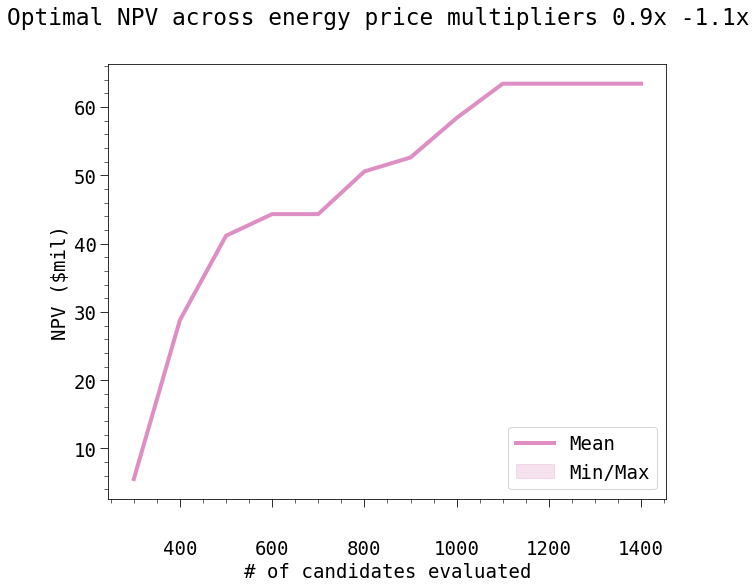

5521692.76252748


In [39]:
current_run = run_group = 'EP4.25_GC_1_NPV'
runs = data_sets[run_group]
site_fig_size = (5,7)
best_solution, evaluation, score, baseline_value = plot_sites(runs, run_group, site_fig_size)
print(best_solution, evaluation, score, baseline_value)

ordering = [current_run]
print(baseline_value)
fig, ax, ax2 = plot_perf(aggregated_data_sets, 0.1, ordering)
plt.legend(["Mean", "Min/Max"], loc='lower right')

plt.suptitle("Optimal NPV across energy price multipliers 0.9x -1.1x")
plt.show()
print(baseline_value)

Could not fit 239848.953 kw into existing PV layout parameters of PVGridParameters(x_position=0.3512411966085236, y_position=0.4262158621687766, aspect_power=1.7731139839826067, gcr=0.329233414950439, s_buffer=5.001064443809419, x_buffer=3.0474801348105607)


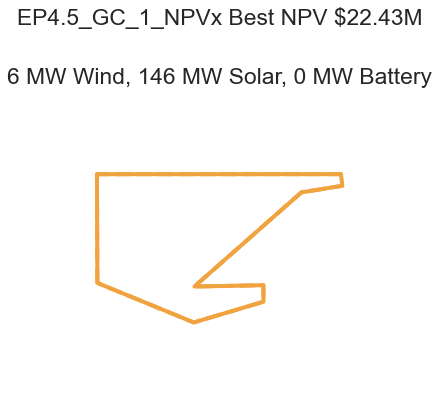

[7.471883872099422, 1.0, 1.0338314905360235, 0.0708678010521322, 1.0, 0.0, 0.3512411966085236, 0.4262158621687766, 1.7731139839826067, 0.329233414950439, 5.001064443809419, 3.0474801348105607, 0.7994974776989321, 0.000476976997019863] 22432527.176802386 22432566.86076626 EP4.5_GC_1_NPV
-37621914.26328994
EP4.5_GC_1_NPV mean 22.43256686076626 stdev nan median 22.43256686076626



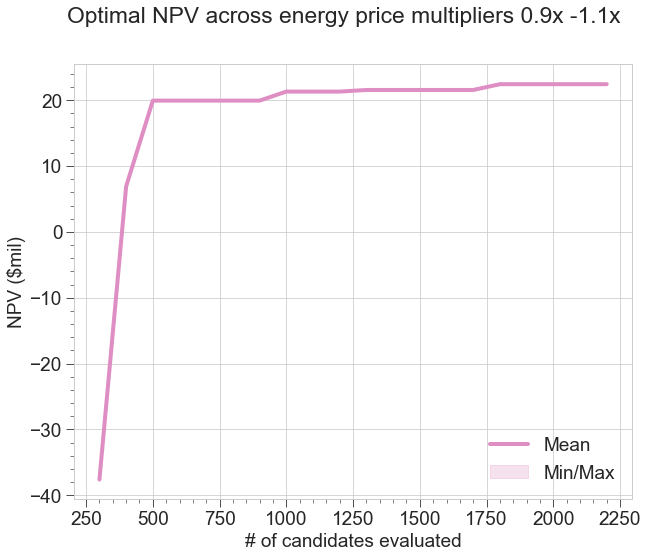

-37621914.26328994


In [88]:
current_run = run_group = 'EP4.5_GC_1_NPV'
runs = data_sets[run_group]
site_fig_size = (5,7)
best_solution, evaluation, score, baseline_value = plot_sites(runs, run_group, site_fig_size)

ordering = [current_run]
print(baseline_value)
fig, ax, ax2 = plot_perf(aggregated_data_sets, 0.1, ordering)
plt.legend(["Mean", "Min/Max"], loc='lower right')

plt.suptitle("Optimal NPV across energy price multipliers 0.9x -1.1x")
plt.show()
print(baseline_value)

Could not fit 235774.179 kw into existing PV layout parameters of PVGridParameters(x_position=0.7369359707637884, y_position=0.45205959375544646, aspect_power=2.240607255718554, gcr=0.36132709937426405, s_buffer=5.003081324262412, x_buffer=6.757572842951429)


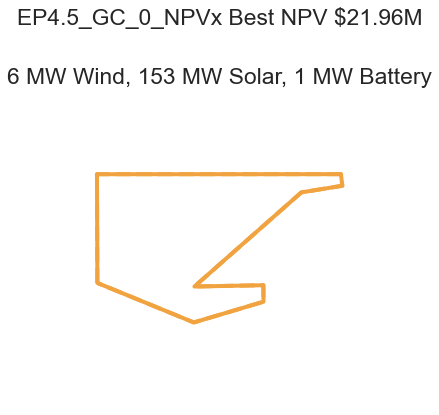

[1.1683146289488662, 0.9677267949422254, 2.0265365617141775, 3.059647319144945, 0.8983619337991764, 0.0, 0.7369359707637884, 0.45205959375544646, 2.240607255718554, 0.36132709937426405, 5.003081324262412, 6.757572842951429, 0.7859149117497397, 0.0022261083941290637] 21958330.478431657 21958408.888789177 EP4.5_GC_0_NPV
-41575805.7390924
EP4.5_GC_0_NPV mean 21.958408888789176 stdev nan median 21.958408888789176



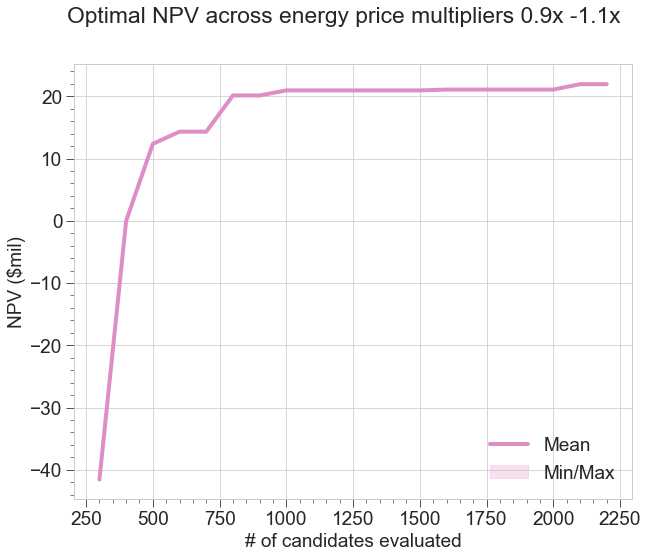

-41575805.7390924


In [89]:
current_run = run_group = 'EP4.5_GC_0_NPV'
runs = data_sets[run_group]
site_fig_size = (5,7)
best_solution, evaluation, score, baseline_value = plot_sites(runs, run_group, site_fig_size)

ordering = [current_run]
print(baseline_value)
fig, ax, ax2 = plot_perf(aggregated_data_sets, 0.1, ordering)
plt.legend(["Mean", "Min/Max"], loc='lower right')

plt.suptitle("Optimal NPV across energy price multipliers 0.9x -1.1x")
plt.show()
print(baseline_value)

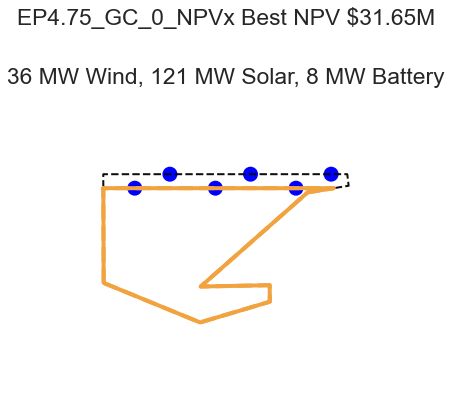

[1.947294194049336, 1.0, 0.5177757160667842, -3.2711833476445102, 0.0, 0.16100450148740592, 0.8975477088354141, 0.22460376661004944, -0.9002472012139167, 0.3206161684176608, 6.499548550976856, 2.527853601415318, 0.40428714040819014, 0.02644439286240078] 31653384.728356875 31653434.031361878 EP4.75_GC_0_NPV
-31927341.976143386
EP4.75_GC_0_NPV mean 32.71264879263058 stdev nan median 32.71264879263058



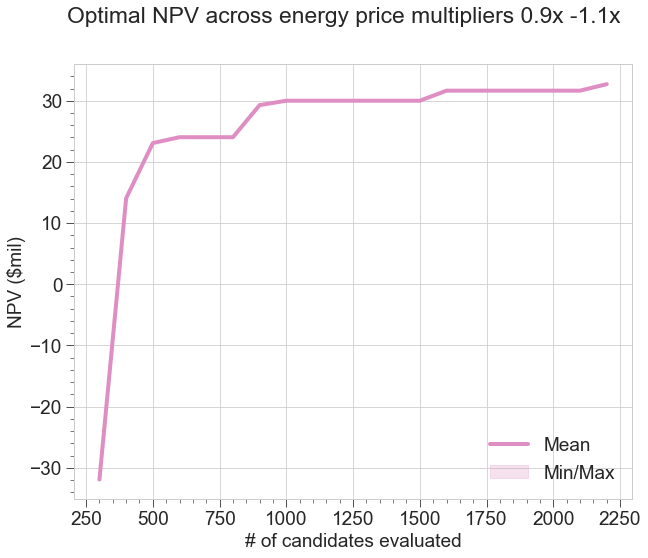

-31927341.976143386


In [87]:
current_run = run_group = 'EP4.75_GC_0_NPV'
runs = data_sets[run_group]
site_fig_size = (5,7)
best_solution, evaluation, score, baseline_value = plot_sites(runs, run_group, site_fig_size)

ordering = [current_run]
print(baseline_value)
fig, ax, ax2 = plot_perf(aggregated_data_sets, 0.1, ordering)
plt.legend(["Mean", "Min/Max"], loc='lower right')

plt.suptitle("Optimal NPV across energy price multipliers 0.9x -1.1x")
plt.show()
print(baseline_value)

Could not fit 251895.441 kw into existing PV layout parameters of PVGridParameters(x_position=0.5444040617598364, y_position=0.6245781675341692, aspect_power=2.3119516096242223, gcr=0.3693071739510719, s_buffer=0.0, x_buffer=3.0904779751904785)


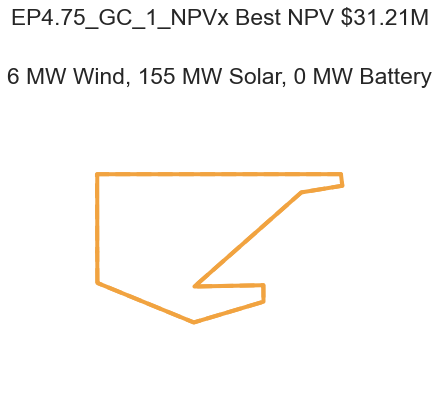

[7.066480807614397, 0.11536848727063803, 0.0, -1.061488838668058, 0.6313570707703162, 0.0, 0.5444040617598364, 0.6245781675341692, 2.3119516096242223, 0.3693071739510719, 0.0, 3.0904779751904785, 0.8396522055850598, 8.82898144677624e-05] 31212281.082439207 31212301.550926417 EP4.75_GC_1_NPV
-20542478.678487595
EP4.75_GC_1_NPV mean 31.212301550926416 stdev nan median 31.212301550926416



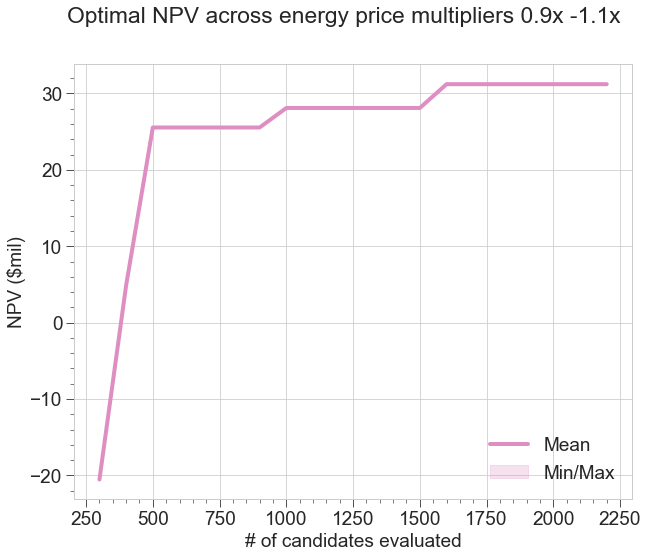

-20542478.678487595


In [86]:
current_run = run_group = 'EP4.75_GC_1_NPV'
runs = data_sets[run_group]
site_fig_size = (5,7)
best_solution, evaluation, score, baseline_value = plot_sites(runs, run_group, site_fig_size)

ordering = [current_run]
print(baseline_value)
fig, ax, ax2 = plot_perf(aggregated_data_sets, 0.1, ordering)
plt.legend(["Mean", "Min/Max"], loc='lower right')

plt.suptitle("Optimal NPV across energy price multipliers 0.9x -1.1x")
plt.show()
print(baseline_value)

-24402859.282458786
default_no_grid_charge_results mean 154.83829219326643 stdev 53.270478226293754 median 152.81220484756125

default_high_wind_no_grid_charge_results mean 183.46389708250732 stdev 53.34723909497129 median 183.4769111844542

high_wind_no_grid_charge_results mean 26.878491846333187 stdev 31.380819874937742 median 19.272171417575716

financial_no_grid_charge_results mean 12.40510101550804 stdev 20.649237664379935 median 0.9731365677457601



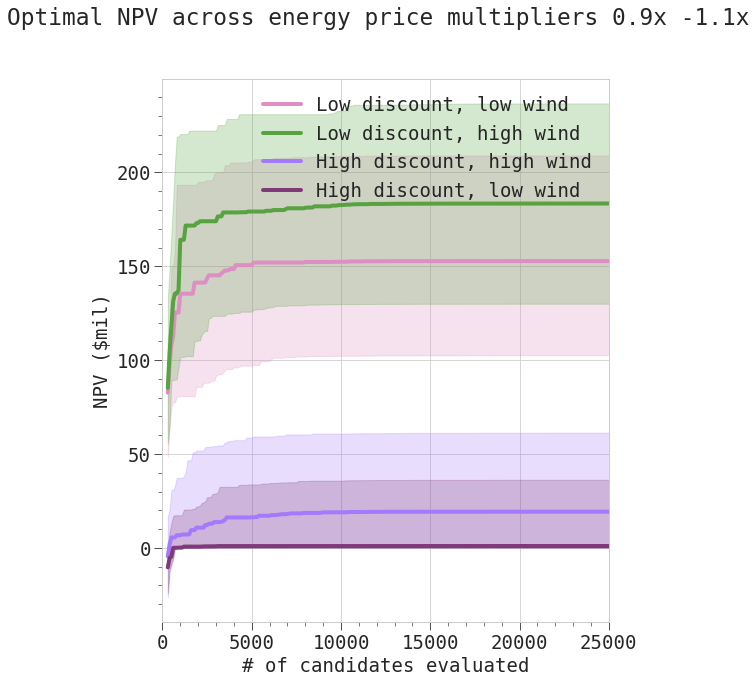

-24402859.282458786


In [237]:
ordering = ("default_no_grid_charge_results", "default_high_wind_no_grid_charge_results", "high_wind_no_grid_charge_results", "financial_no_grid_charge_results")
print(baseline_value)
fig, ax, ax2 = plot_perf(aggregated_data_sets, 0.1, ordering, (8, 10))
plt.legend(["Low discount, low wind", "Low discount, high wind", "High discount, high wind", "High discount, low wind"], loc='upper right')

# ax.set_ylim(3.1, 4.5)
# ax.set_yticks([3.5, 4.0, 4.5])
ax.set_xlim(0, 25000)
# ax.set_xticks([0,10000,20000,30000,40000,50000])
# ax2.set_yticks([219, 220, 221])
plt.suptitle("Optimal NPV across energy price multipliers 0.9x -1.1x")
plt.show()
# plt.savefig(name + 'progress.svg')
print(baseline_value)

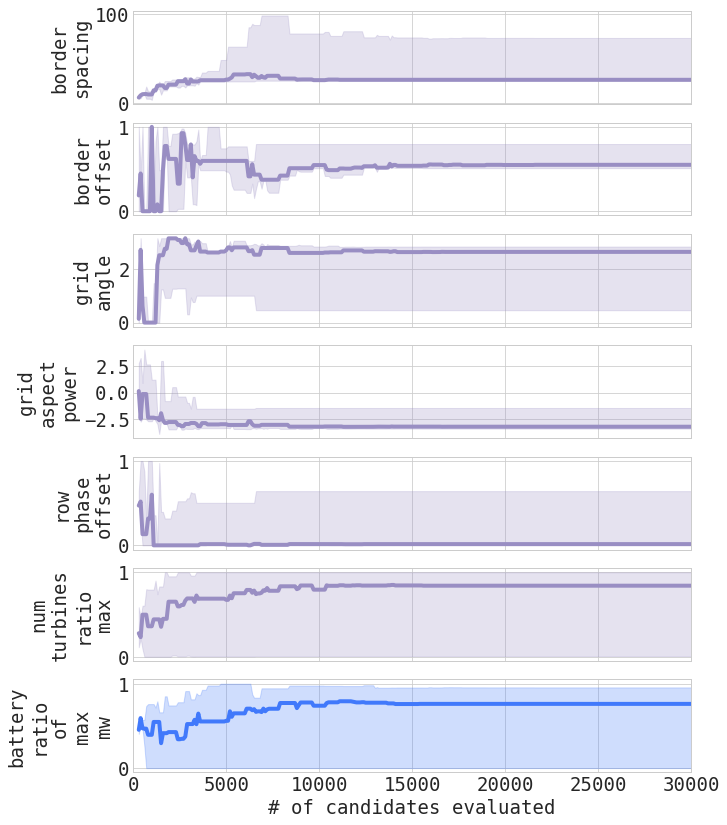

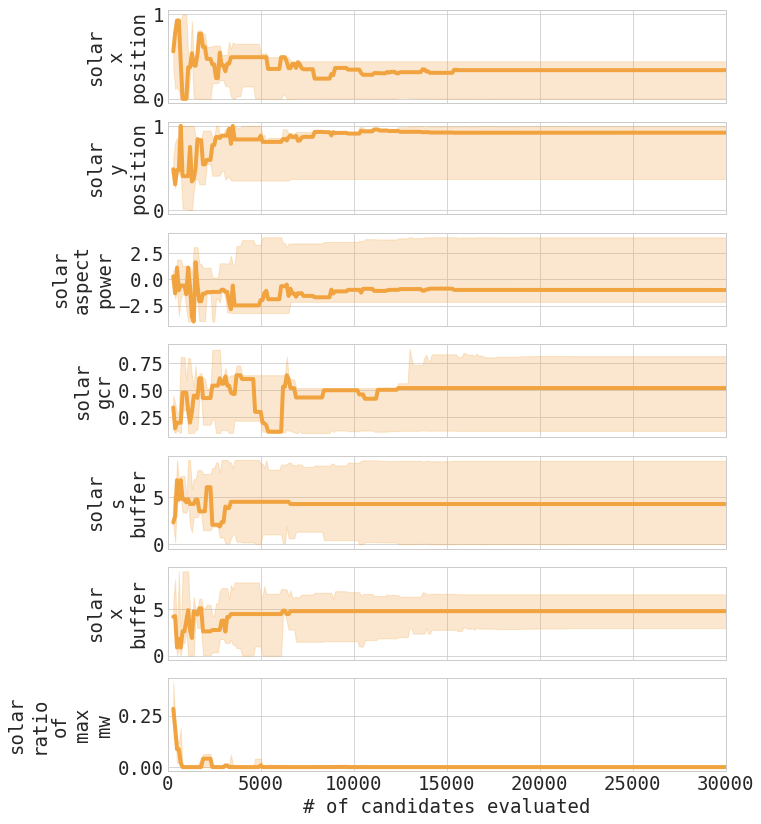

In [150]:
run_group = 'high_wind_no_grid_charge_results'
aggregated_data_sets = make_aggregated_data_set(data_sets)

solar_vars = [var for var in solution_vars if var.startswith('solar')]
wind_vars = [var for var in solution_vars if not var.startswith('solar') and not var.startswith('batt')]
batt_vars = [var for var in solution_vars if var.startswith('batt')]


def plot_solution_vars(solution_vars):
    fig, axs = plt.subplots(len(solution_vars), sharex=True, figsize=[10,2*len(solution_vars)])
    for i, var in enumerate(solution_vars):
        col_name = 'best_solution.' + var
        ax = axs[i]
        ax.set_xlim(0, 30000)
        ax.set(ylabel=var.replace('_','\n'))
        run_data = aggregated_data_sets[run_group]
        x = run_data['num_evaluations'].median(1) + 200
        if var.startswith('batt'):
            color = batt_color
        elif var.startswith('solar'):
            color = solar_color 
        else:
            color = wind_color
        plot_quantiles(ax, x, run_data[col_name], color=color)

    plt.xlabel('# of candidates evaluated')

plot_solution_vars(wind_vars + batt_vars)
# plt.savefig(name + 'solution_trajectories_solar.svg')

plot_solution_vars(solar_vars)
# plt.savefig(name + 'solution_trajectories_wind.svg')